# Statistical Validation

## Implicit Data Assumptions

You collect data in realtime and build models to analyze this data. Your decisions depend on this data. But most statistical theory relies on data honoring parametric assumptions; assumptions that the data (or more correctly the residuals) are normally distributed. Second that this data is stationary and not drifting in its characteristics. Because if it is drifting, the assumptions for when the model was built and validated may not stand true at the time of scoring.

Instead of assuming the de facto validity and stability of the parameters, it is critical that you build-in safety measures to actively monitor, alert, and trigger any violations of these assumptions. Below we build a few of these implicit tests. We will demonstrate conducting three tests -- 

1. First that the observations indeed are unbiased and sampled from a normal distribution.
2. Second that the attributes/features of observation indeed are discrminant enough for inclusion into the model.
3. Third, assess the distribution to best describe the observations if they do not follow the normal distribution.

# Normality Validation

Central limit theorem (https://en.wikipedia.org/wiki/Central_limit_theorem) is a pivotal statistical theorem that confers a level of assurance that most random unbiased samples tend to aggregate (sum) into a normal curve (with a specific mean and standard deviation) and that as the number of samples increase, the distribution approximates normality more closely.</p>
<p>Given this observation, if we believe our samples (data measures) are truly from an unbiased sample, it is safe to assume our data is normal. There are two tests we can do easily if the normality assumption holds true. They are --

1. *Is the data "normal"* -- a nice gaussian distribution?
2. *Is the data stationary* over time -- meaning has it drifted over time?

Let us accomplish a test for both.

## Testing the "bell" shape

The test for normality, in simple terms, is a test to see if the curve looks like a nice symmetric bell with a defined peak and a taper down. We will create synthetic datasets, one normal and another non-normal, to test.

In [1]:
from scipy import stats

# Create the normal series of 1000 numbers, around the mean (peak) of 10 and a standard deviation of 5 (spread)
n_series = np.random.normal(10, 5, 1000)

# Create 100 numbers randomly
non_n_series = stats.uniform.rvs(size=1000) * 20

Let us plot the two synthetic distributions to visually gauge the curvature and peak of the bells.

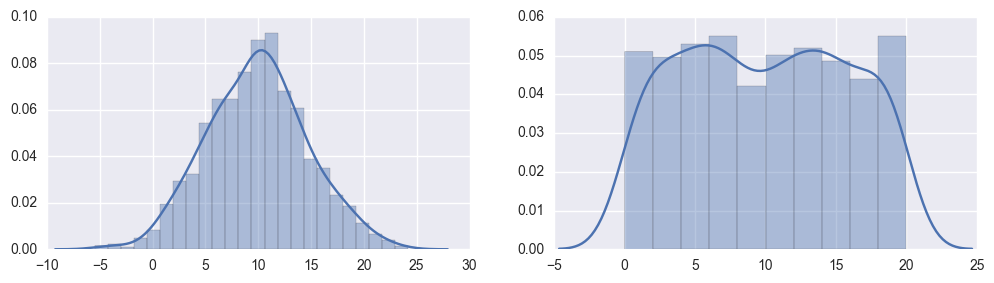

In [2]:
%matplotlib inline
from scipy import stats, integrate

# Plot the two series
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.distplot(n_series, ax=ax1)

# Visually, you should already see central limit theorem at 100 values (the kernel desnity) 
# almost looking like a normal distribution
sns.distplot(non_n_series, ax=ax2);

### *Is the data "normal"?*

Spot a bell curve?

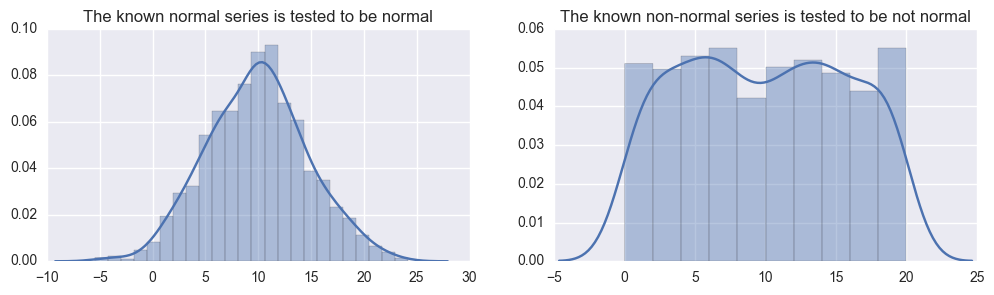

In [3]:
from scipy import stats

# Test if the X is normal; centered around zero and nicely distributed.
def test_norm(x):
    # Conduct Kolmogorov-Smirnov test for normality
    (kstat, pvalue) = stats.mstats.normaltest(x)
    return pvalue > 0.05


# Plot two side-by-side plots -- one normal and one non-normal
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.distplot(n_series, ax=ax1)
# Put the results of our investigation into normality as plot title
ax1.set_title('''The known normal series is tested to be {0}normal'''.format(
    "" if test_norm(n_series) else "not "))
sns.distplot(non_n_series, ax=ax2)
# Put the results of our investigation into non-normality as plot title
ax2.set_title('''The known non-normal series is tested to be {0}normal'''.
              format("" if test_norm(non_n_series) else "not "))
plt.show();

### *Is the data "stationary"?*

We also want to spot if a series that is presumably stationary, meaning the peak and the shape remains relatively static, is still stationary over time. Because we do not have the luxury of the time, let us create two more more synthetic normal series.

1. One normal series has the same standard deviation (of 5) but different mean as our prior good distribution -- meaning the expanse of the distrbution has not changed too substantively.
2. The other series has the same mean (of 10) but different standard deviation to show the curvature has changed but peak remains at the same mean.

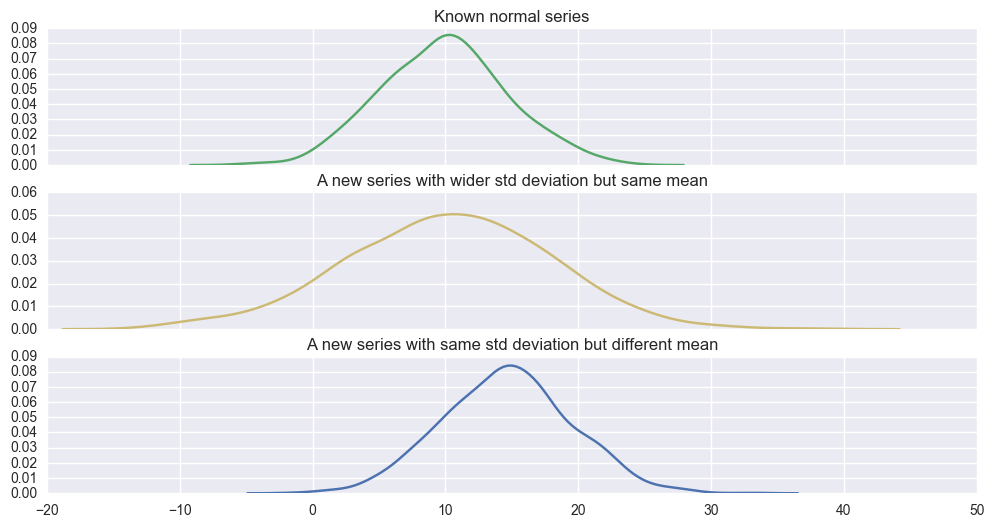

In [4]:
# Make a copy of our known prior series
known_n_series = n_series

# Create a new series with same mean of 10 but wider standard deviation
n_series_with_diff_stddev = np.random.normal(10, 8, 1000)

# Create another new series with same standard deviation but mean higher than previous
n_series_with_diff_mean = np.random.normal(15, 5, 1000)

# Plot the series to visually show the series; share X axis to we can compare mean and variance
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

# Original series is green
sns.distplot(known_n_series, color="g", hist=False, ax=ax1)
ax1.set_title('Known normal series')

# Wider series is yellow
sns.distplot(n_series_with_diff_stddev, color="y", hist=False, ax=ax2)
ax2.set_title('A new series with wider std deviation but same mean')

# Shifted series is blue
sns.distplot(n_series_with_diff_mean, color="b", hist=False, ax=ax3)
ax3.set_title('A new series with same std deviation but different mean');

#### *Has the series shifted its "center"/mean?*

In [5]:
# Do two series have same mean?
def test_mean_drift(x, y):
    (tstat, pvalue) = stats.ttest_ind(x - x.mean(), y - x.mean())
    print "The series have" + (" different "
                               if pvalue <= 0.05 else " same ") + "mean"
    return pvalue <= 0.05


#Test drift when series has not moved; can have different variance
test_mean_drift(known_n_series, n_series_with_diff_stddev)

#Test drift when series has moved 5 unit
test_mean_drift(known_n_series, n_series_with_diff_mean);

The series have same mean
The series have different mean


#### *Has the series's variance/expanse changed?*

In [6]:
# Do two series have same variance?
def test_var_drift(x, y):
    #Use levene test to test variance; also called homoscedasticity
    (tstat, pvalue) = stats.levene(x - x.mean(), y - y.mean())
    print "The series have" + (" different " if pvalue <= 0.05 else " same "
                               ) + "standard deviation"
    return pvalue <= 0.05


# Test variance drift when series has not moved
test_var_drift(known_n_series, n_series_with_diff_mean)

# Test variance drift when series has moved
test_var_drift(known_n_series, n_series_with_diff_stddev);

The series have same standard deviation
The series have different standard deviation


# Feature Evaluation

Given two normal series, it is relatively easy to spot the stationarity or significant differences. However, when you have multiple normal series, the permutorial combinations for significant difference tests can be substantively computational and error prone unless variance (scatter distance) across all the series are normalized.

Consider the following example of a wine dataset. There are three kinds/classes of wines each with different (or we believe) levels of malic acid, ash, magnesium, phenols, color hue etc. In order to determine if malic acid is a substantive feature that distinguishes the class of wine, we need to compare 3 distributions, wine 1 with wine 2, wine 2 with wine 3, and wine 1 with wine 3. And we need to repeat the exercise for every feature like acidity, hue etc before tossing it into the model.

Underneath, we show we may use pairwise tests to check for significant differences between series. This test isn't so much the stationarity test although similar theory is at play. It is used to identify significant attributes and differences relevant for the model (model that signifies the class of wine in our example).

Based on a real wine dataset (http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names), analyze if there is substantive difference in alohol and malic acid levels of three kinds of wine.

In [7]:
# Download the wine dataset
# Initialize the data model that one would expect from the dataset
col_names = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue', 'OD280_OD315', 'Proline'
]

# Fetch the data
wines = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    names=col_names,
    index_col=False)

# Change the class of the wine to a categorical type from numeric type
wines['WineClass'] = wines.Class.apply(lambda x: 'Wine ' + str(x))

# Display a preview
pd_display(wines, 'Wines dataset from UCI machine learning website')

,Class,Alcohol,Malic acid,Ash,...,Hue,OD280_OD315,Proline,WineClass
0,1,14.23,1.71,2.43,...,1.04,3.92,1065,Wine 1
1,1,13.20,1.78,2.14,...,1.05,3.40,1050,Wine 1
2,1,13.16,2.36,2.67,...,1.03,3.17,1185,Wine 1
...,...,...,...,...,...,...,...,...,...
175,3,13.27,4.28,2.26,...,0.59,1.56,835,Wine 3
176,3,13.17,2.59,2.37,...,0.60,1.62,840,Wine 3
177,3,14.13,4.10,2.74,...,0.61,1.60,560,Wine 3


## Group Differences

Can we visually, along each feature attribute, see if the means and standard deviations are different across the three wine groups?

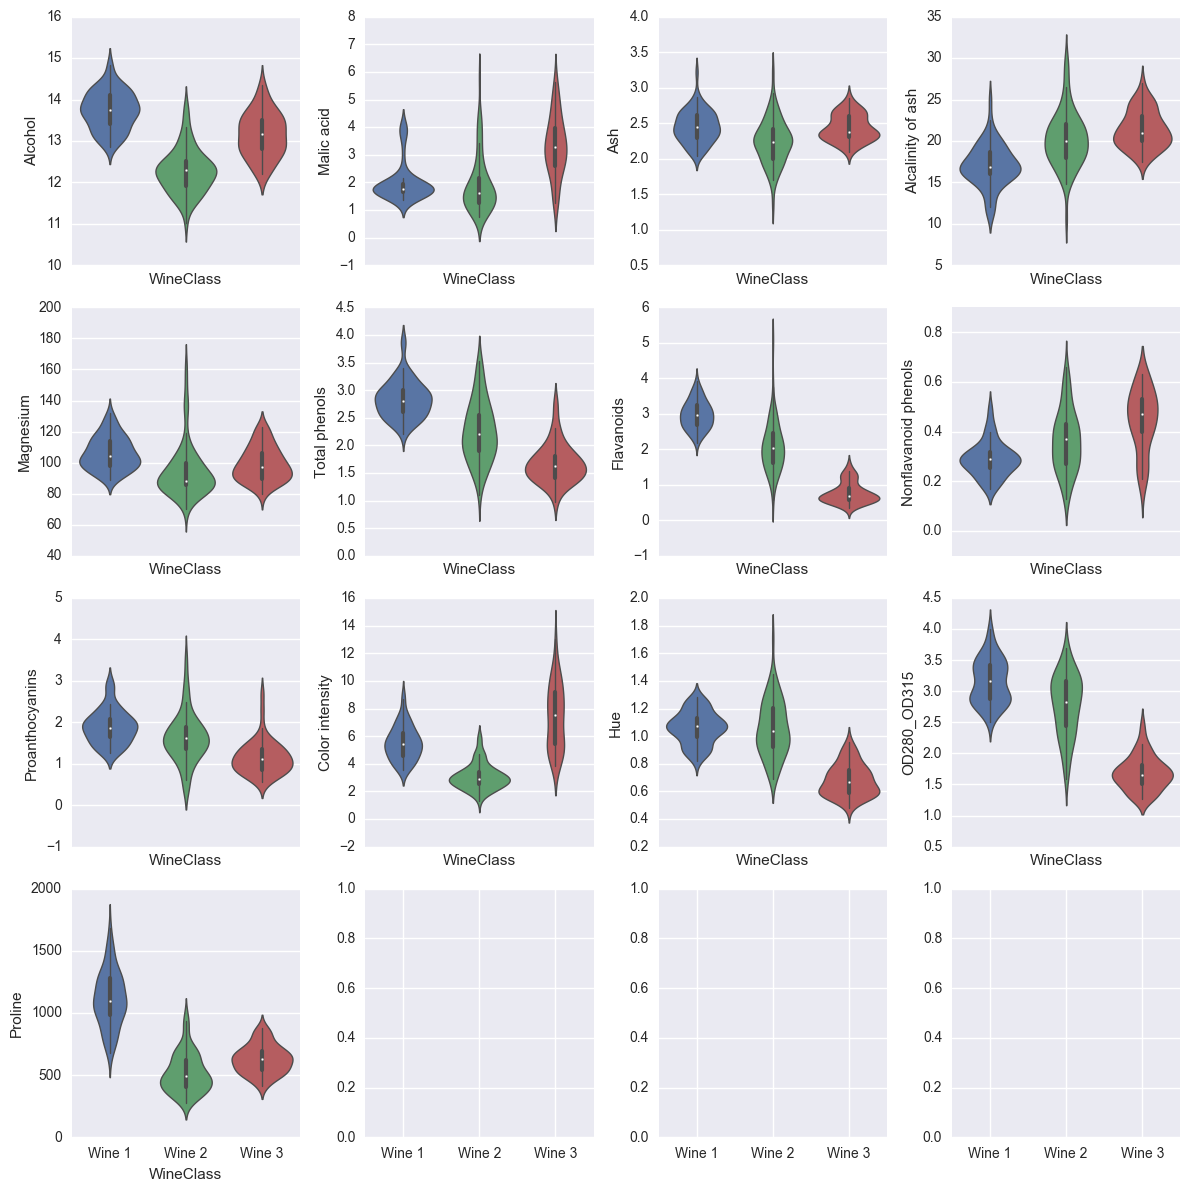

In [8]:
# Find all "continuous/numerical features" that can predict the class of wine
all_measures = wines[[x for x in wines.select_dtypes(include=['number']).columns.values if 'Class' not in x]]

# What are we plotting means against
class_feature = 'WineClass'

# Plot the violin plots to spot feature differences
fig, axes = plt.subplots(nrows=len(all_measures.columns)/4 + 1, ncols=4, sharex=True, figsize=(12,12))

for i, col in enumerate(all_measures.columns):
    sns.violinplot(data=wines, y=col, x='WineClass', ax=axes[i/4, i%4], linewidth=1)
    sns.despine()

plt.tight_layout()

### Do the wines differ?

Just visually looking at the malic acid and ash plots, the means and standard deviations of wine 1 and wine 2 for malic acid; and wine 1 and wine 3 for ash do not seem too far off from each other. The plots and these tests, besides telling us what individual class differences, can be useful in spotting the useful features that could be leveraged to build a wine classification automaton if we were to keep the model parsimonious (aka feature selection).

Let us also compute (besides visual plotting before) if the means and standard deviations are different across the three wine groups along other features. If the features are distinctly different along different wine classes, that means the feature is discriminatory enough to be included into the automaton system.

In [9]:
# Are the feature/per-feature measurement "clumps" similar between wines
# We will conduct Tukey test to find pairwise differences. Tukey test is similar to ttest
# But since we have multiple groups (wine 1, 2, and 3 leading to 1-2, 2-3, 1-3 comparisons) 
# it is better to use tukey test (or bonferroni test) since stddev is normalized across the groups
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Along each feature, compare the wines and see if the mean/variance is significantly different
for feature in all_measures:
    compare_result = pairwise_tukeyhsd(wines[feature], wines[class_feature])
    display(
        HTML(
            '<span class="{2} text-center simpletable"><caption class="caption">When comparing <u><i>{0}</i></u>, we conclude {4} groups are {1}</caption><div class="row center text-center col-lg-12">{3}</div></span>'.
            format(feature, 'different' if any(compare_result.reject) else
                   'same', 'text-primary' if any(compare_result.reject) else
                   'text-muted', compare_result._results_table.as_html(), np.count_nonzero(compare_result.reject))))

group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-1.466,-1.6792,-1.2528,True
Wine 1,Wine 3,-0.591,-0.8262,-0.3558,True
Wine 2,Wine 3,0.875,0.6489,1.1012,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.078,-0.4703,0.3143,False
Wine 1,Wine 3,1.3231,0.8902,1.756,True
Wine 2,Wine 3,1.4011,0.9849,1.8172,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.2108,-0.3179,-0.1038,True
Wine 1,Wine 3,-0.0185,-0.1366,0.0996,False
Wine 2,Wine 3,0.1923,0.0787,0.3058,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,3.2007,2.0223,4.3791,True
Wine 1,Wine 3,4.3794,3.0791,5.6796,True
Wine 2,Wine 3,1.1786,-0.0713,2.4286,False


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-11.7897,-17.3872,-6.1922,True
Wine 1,Wine 3,-7.0265,-13.2027,-0.8503,True
Wine 2,Wine 3,4.7632,-1.1742,10.7006,False


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.5813,-0.7634,-0.3992,True
Wine 1,Wine 3,-1.1614,-1.3624,-0.9605,True
Wine 2,Wine 3,-0.5801,-0.7733,-0.3869,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.9015,-1.1198,-0.6833,True
Wine 1,Wine 3,-2.2009,-2.4418,-1.9601,True
Wine 2,Wine 3,-1.2994,-1.5309,-1.0679,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,0.0737,0.0282,0.1191,True
Wine 1,Wine 3,0.1575,0.1073,0.2077,True
Wine 2,Wine 3,0.0838,0.0356,0.1321,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.269,-0.4757,-0.0624,True
Wine 1,Wine 3,-0.7458,-0.9738,-0.5178,True
Wine 2,Wine 3,-0.4767,-0.6959,-0.2576,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-2.4417,-3.0712,-1.8122,True
Wine 1,Wine 3,1.8679,1.1734,2.5625,True
Wine 2,Wine 3,4.3096,3.6419,4.9774,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.0058,-0.0709,0.0594,False
Wine 1,Wine 3,-0.3793,-0.4512,-0.3074,True
Wine 2,Wine 3,-0.3736,-0.4427,-0.3044,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-0.3724,-0.5394,-0.2055,True
Wine 1,Wine 3,-1.4743,-1.6585,-1.29,True
Wine 2,Wine 3,-1.1018,-1.2789,-0.9247,True


group1,group2,meandiff,lower,upper,reject
Wine 1,Wine 2,-596.2048,-667.9839,-524.4258,True
Wine 1,Wine 3,-485.816,-565.0163,-406.6158,True
Wine 2,Wine 3,110.3888,34.2502,186.5274,True


It so turns out all features of the wine are distinct enough between the various wine classes.

# Distribution Checks

Data is not always "clean". Perhaps there is a stochastic process that drifts into an anamolous state; or perhaps data is just spotty and the NaN practices lead to wrongful values in the data. Either case, missing data and wrongful data can cause our normality assumptions to be easily violated. Different parametric assumptions must be applied if we determine that the normality is invalid. Below, we spot missing values, outlier values, and best distribution to describe incoming data.

We will use the air quality dataset at https://archive.ics.uci.edu/ml/datasets/Air+Quality. The datasets are chemical readings at various time intervals.

In [10]:
import requests, zipfile, StringIO

# Let us read the air quality dataset from UCI -- https://archive.ics.uci.edu/ml/datasets/Air+Quality
uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'

# Read the data from the web
air_quality = pd.read_excel(zipfile.ZipFile(StringIO.StringIO(requests.get(uri).content)).open('AirQualityUCI.xlsx'))

# Display a preview of the data
pd_display(air_quality, 'Air quality readings of ~ 1 year between 2004-2005')

,Date,Time,CO(GT),PT08.S1(CO),...,PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,...,1267.50,13.60,48.88,0.76
1,2004-03-10,19:00:00,2.0,1292.25,...,972.25,13.30,47.70,0.73
2,2004-03-10,20:00:00,2.2,1402.00,...,1074.00,11.90,53.98,0.75
...,...,...,...,...,...,...,...,...,...
9354,2005-04-04,12:00:00,2.4,1142.00,...,1092.00,26.90,18.35,0.64
9355,2005-04-04,13:00:00,2.1,1002.50,...,769.75,28.32,13.55,0.51
9356,2005-04-04,14:00:00,2.2,1070.75,...,816.00,28.50,13.12,0.50


## Time Series

The data is temporal in nature with continuous readings every hour. But the Pandas DataFrame treats the day and time of recording distinctly. In order to plot continuous maps (and study the trends), it is important to turn this data into a "time-series".

In [11]:
# Create time index
air_quality_ts = air_quality.copy()

# Convert date and time into string forms
air_quality_ts['Date'] = air_quality_ts.Date.astype('str')
air_quality_ts['Time'] = air_quality_ts.Time.astype('str')

# Create a Datetime column
air_quality_ts['datetime'] = air_quality_ts.apply(lambda x : pd.to_datetime(x.Date + ' ' + x.Time), axis=1)

# Change the index into a time series
air_quality_ts.set_index('datetime', inplace=True)

# Drop Date and Time since we already have the index
air_quality_ts.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert everything to numeric datatype
air_quality_ts = air_quality_ts.astype('float')

# Display a preview
pd_display(air_quality_ts, 'Air quality data rendered as time series.')

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),...,PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150.0,11.88,...,1267.50,13.60,48.88,0.76
2004-03-10 19:00:00,2.0,1292.25,112.0,9.40,...,972.25,13.30,47.70,0.73
2004-03-10 20:00:00,2.2,1402.00,88.0,9.00,...,1074.00,11.90,53.98,0.75
...,...,...,...,...,...,...,...,...,...
2005-04-04 12:00:00,2.4,1142.00,-200.0,12.37,...,1092.00,26.90,18.35,0.64
2005-04-04 13:00:00,2.1,1002.50,-200.0,9.55,...,769.75,28.32,13.55,0.51
2005-04-04 14:00:00,2.2,1070.75,-200.0,11.93,...,816.00,28.50,13.12,0.50


## Visual "outliers"

Let us spot the trends visually to spot any outlier data. As is evident in the tabular display above, there are some readings that should a -200.0 leading to suspect readings. Plotting may reveal if the distribution is indeed "normal".

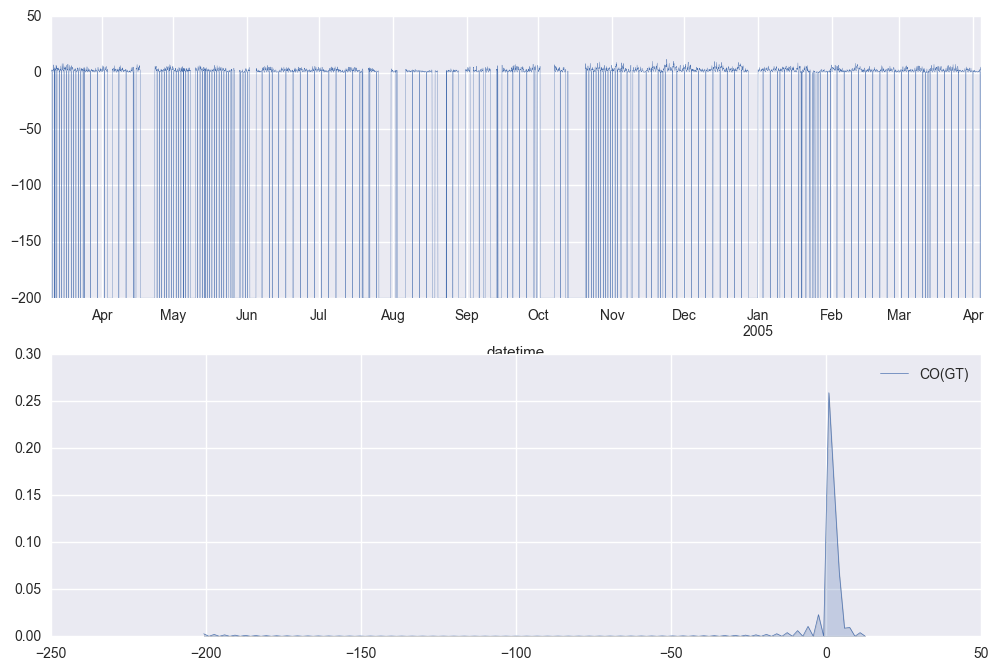

In [12]:
%matplotlib inline
# Plot the time series
sns.set(color_codes=True)

# Create chart area
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot the CO(GT) column -- Hourly averaged concentration CO
series = air_quality_ts['CO(GT)']

# Plot both trend line
series.plot(ax=ax[0], linewidth=0.25)

# And the kernel density distribution
sns.kdeplot(series, shade=True, ax=ax[1], linewidth=0.5);

## Plot Observations

The plot seems to suggest that the distribution is bipolar -- the normal range mostly lies between [0, 10] and abnormal range is indicated with a -200.

## Separating the outliers

Let us use simple three sigma measure to separate the outliers. If you see the https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule, it suggests that most of all normal values lie within two standard deviations of the mean. Anything outside these "normal" distributions is perhaps a outlier. Let us spot where the outliers exist.

In [13]:
from scipy import stats
# Convert our original values into a dataframe
co_df = series.to_frame()

# Compute a column where the (absolute) deviation of value is beyond two standard deviations away
co_df['is_outlier'] = (np.abs(stats.zscore(co_df['CO(GT)'])) > 2)

# Show abnormal/outlier values
pd_display(co_df[co_df.is_outlier], "Points where the sensor recorded an outlier value")

,CO(GT),is_outlier
datetime,,
2004-03-11 04:00:00,-200.0,True
2004-03-12 04:00:00,-200.0,True
2004-03-12 09:00:00,-200.0,True
...,...,...
2005-03-29 04:00:00,-200.0,True
2005-04-01 04:00:00,-200.0,True
2005-04-04 04:00:00,-200.0,True


If we exclude the outlier values and treat the observations, are the observations normal?

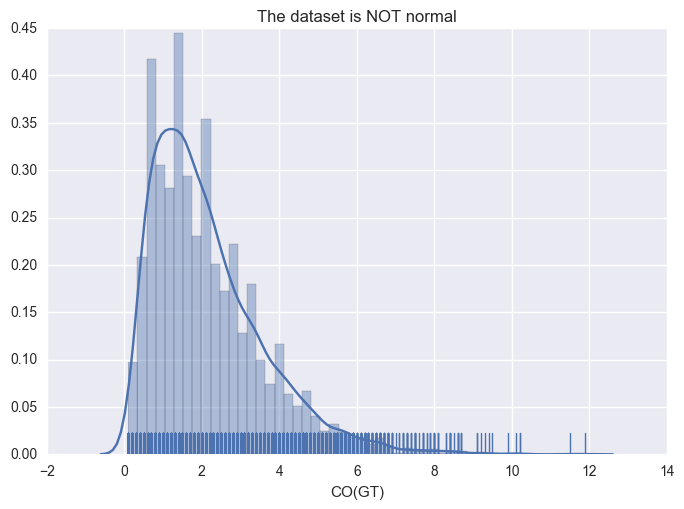

In [14]:
# Also plot "normal" values for visually cleaner dataset
good_values = co_df[~co_df.is_outlier]['CO(GT)']

ax = sns.distplot(good_values, rug=True, hist=True);

# Check for normality of the good values to make sure we may now do parametric tests
ax.set_title("The dataset is {0} normal".format("NOT" if stats.mstats.normaltest(good_values)[1] < 0.05 else ""));

## Findings

It seems to suggest from (preview of the dataframe) that the sensor is misbehaving at 4AM in the morning usually. Something to consider?

Moreover, it looks the data is not really "normally" distributed -- the distinct bell shape is not apparent. It seems to be skewed. What distribution is this sensor exhibiting? 

In [15]:
# Create a function to run ks test against all known distributions
from math import log
def run_dist_test(x, cdf):
    #fit our data set against every probability distribution
    dist = getattr(stats, cdf)
    #estimate the parameters for known samples -- aka mean, variance, skew etc
    params = dist.fit(good_values)
    # apply the Kolmogorov Smirnov test
    (D, p) = stats.kstest(x, cdf, args=params)
    # if the distribution is significant return the D values else pass null
    return log(p) if not np.isnan(p) and p <= 0.05 and p > 0 else None

# Get all known distributions from the web; for demo we will only check 5 distributions
cdfs = pd.read_html('https://docs.scipy.org/doc/scipy-0.16.1/reference/stats.html')[1][0].to_frame('cdf').head()

# Evaluate the distribution
cdfs['log_pvalue'] = cdfs['cdf'].apply(lambda cdf: run_dist_test(good_values, cdf))

# Display the preview of the cdf evaluations
pd_display(cdfs.dropna().sort_values('log_pvalue'), 'Log likelihood of the values following a known distribution -- smaller is better')

,cdf,log_pvalue
0,alpha,-687.75
4,betaprime,-8.55
3,beta,-8.51


## Alpha Distribution

From the tests of all known distributions, the observed sensor values seem to follow the "alpha" distribution the best. See more about alpha distribution at (http://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/alppdf.htm). Here is how the theoretical distribution and the observed distributions look side-by-side.

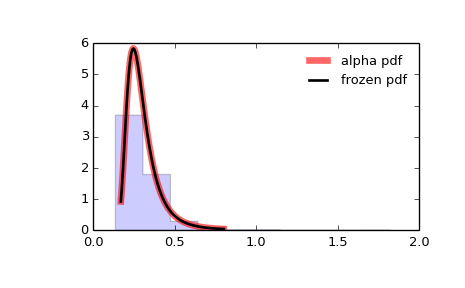

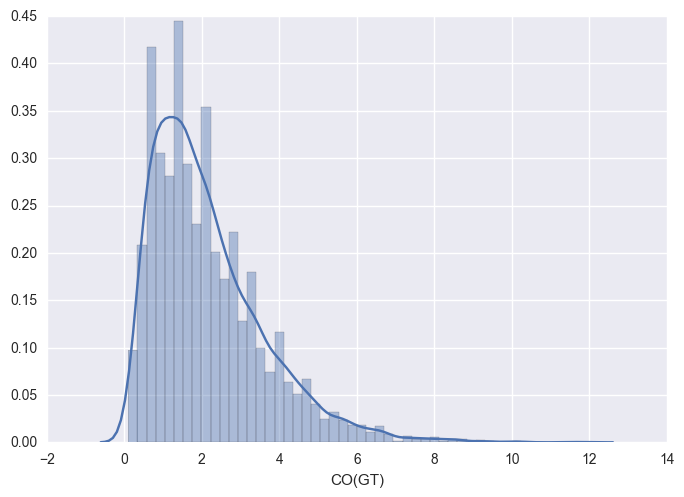

In [16]:
# Plot the observed values
sns.distplot(good_values, rug=False, hist=True);

# Plot the theoretical values
Image('https://docs.scipy.org/doc/scipy-0.16.1/reference/_images/scipy-stats-alpha-1.png')

# Conclusions

Do not just leave the implicit assumptions of your model go unchecked. The data could be drifting, missing, over selecting (features) or changing its inherent shape over time. Build data-awareness in the models.